In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb


In [3]:
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic

# Load and preprocess data
df = pd.read_csv("C:\\Users\\bashp\\Downloads\\my_project\\myenv\\dataset.csv")
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month

In [4]:
drop_columns = ['Unnamed: 0','time','first','last','street','city','state','zip','dob','job','trans_num']
df.drop(columns=[col for col in drop_columns if col in df.columns], inplace=True)


In [5]:
cat_col = ['merchant','category','gender']
encoders = {}
for col in cat_col:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

In [6]:
def haversine(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])
df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [7]:
features = ['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x = df[features]
y = df['class']

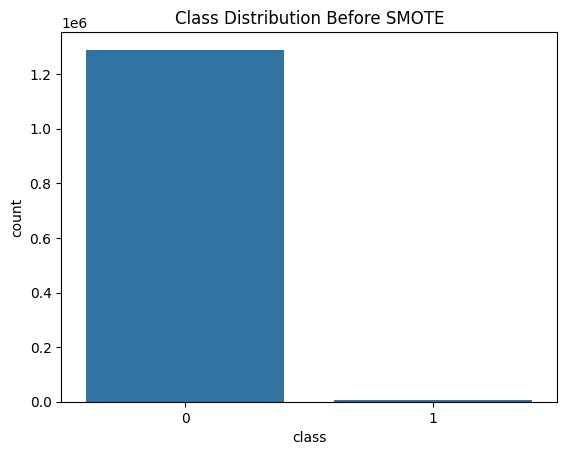

In [8]:
sns.countplot(x='class', data=df)
plt.title("Class Distribution Before SMOTE")
plt.show()


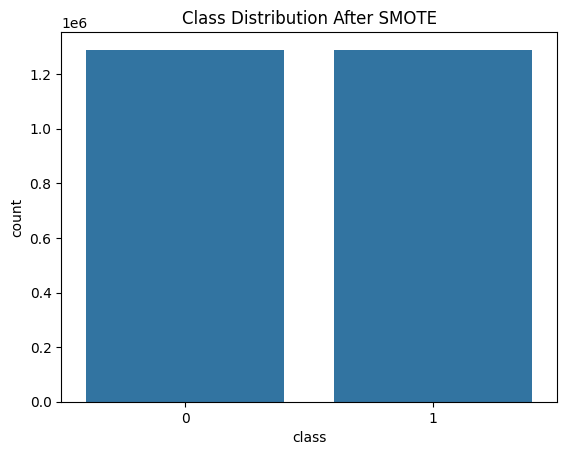

In [9]:
smote = SMOTE(random_state=42)
x_resample, y_resample = smote.fit_resample(x, y)

sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)

In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced',n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42,n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', is_unbalance=True,
                                   learning_rate=0.05, num_leaves=31, max_depth=1, n_estimators=200,n_jobs=-1)
}

In [12]:
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score: ", roc_auc_score(y_test, y_proba))


=== Logistic Regression ===


c:\Users\bashp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bashp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bashp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67    257186
           1       0.00      0.00      0.00    258482

    accuracy                           0.50    515668
   macro avg       0.25      0.50      0.33    515668
weighted avg       0.25      0.50      0.33    515668

ROC AUC Score:  0.4997562041760125

=== Random Forest ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    257186
           1       0.99      1.00      0.99    258482

    accuracy                           0.99    515668
   macro avg       0.99      0.99      0.99    515668
weighted avg       0.99      0.99      0.99    515668

ROC AUC Score:  0.9996900917900141

=== XGBoost ===


c:\Users\bashp\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:15:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97    257186
           1       0.98      0.96      0.97    258482

    accuracy                           0.97    515668
   macro avg       0.97      0.97      0.97    515668
weighted avg       0.97      0.97      0.97    515668

ROC AUC Score:  0.9961963224540418

=== LightGBM ===
[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257
[LightGBM] [Warning] No further s

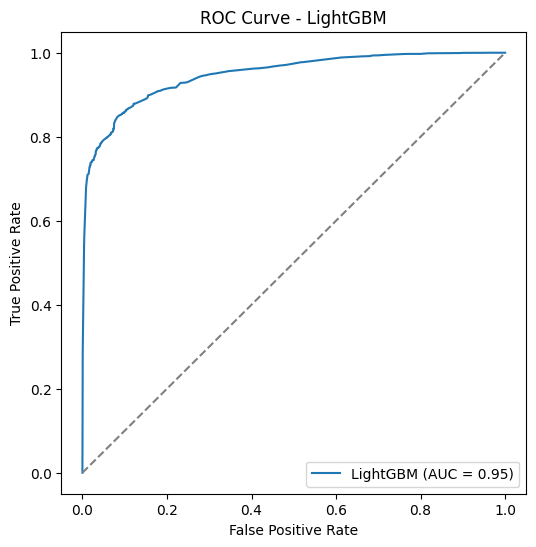

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {name}")
plt.legend(loc="lower right")
plt.show()

In [14]:
joblib.dump(models["LightGBM"], "fraud_detection_model.jb")
joblib.dump(encoders, "label_encoders.jb")

['label_encoders.jb']

In [15]:
df[df['class']==1].head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,class,hour,day,month,distance
2449,4613314721966,543,4,281.06,1,35.9946,-81.7266,885,1325466397,36.430124,-81.179483,1,1,2,1,68.962726
2472,340187018810220,285,2,11.52,0,29.4400,-98.4590,1595797,1325468849,29.819364,-99.142791,1,1,2,1,78.443229
2523,340187018810220,196,4,276.31,0,29.4400,-98.4590,1595797,1325473523,29.273085,-98.836360,1,3,2,1,41.048425
2546,4613314721966,162,2,7.03,1,35.9946,-81.7266,885,1325475483,35.909292,-82.091010,1,3,2,1,34.211963
2553,340187018810220,328,4,275.73,0,29.4400,-98.4590,1595797,1325476547,29.786426,-98.683410,1,3,2,1,44.124854
